## Import The Dataset

## Data Preprocessing

In [1]:
import numpy as np
import time
import copy
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
!pip install timm
import timm

     |████████████████████████████████| 431 kB 537 kB/s            


In [2]:
transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '../input/dataorg/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
data_size = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes   
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [3]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

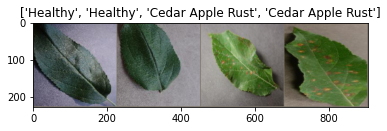

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

## Create a function to train and to evaluate the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

## Declare and Download (optional) the pretrained model

In [6]:
model_resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [7]:
model_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [8]:
model_inceptionv3 = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [9]:
model_alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

# Set the model, parameters to tune, criterion, oprimizer, and the weight update

### AlexNet Architecture

In [10]:
for param in model_alexnet.parameters():
    param.requires_grad = False

num_ftrs = model_alexnet.classifier[6].in_features
model_alexnet.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_alexnet = model_alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_alexnet.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_alexnet = train_model(model_alexnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9806 Acc: 0.7888
val Loss: 0.4218 Acc: 0.9059

Epoch 1/24
----------
train Loss: 0.7186 Acc: 0.8620
val Loss: 0.4619 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.6901 Acc: 0.8694
val Loss: 0.5177 Acc: 0.8667

Epoch 3/24
----------
train Loss: 0.6564 Acc: 0.8821
val Loss: 0.2646 Acc: 0.9490

Epoch 4/24
----------
train Loss: 0.6034 Acc: 0.8883
val Loss: 0.2384 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.6378 Acc: 0.8931
val Loss: 0.4011 Acc: 0.9333

Epoch 6/24
----------
train Loss: 0.5751 Acc: 0.8979
val Loss: 0.3344 Acc: 0.9451

Epoch 7/24
----------
train Loss: 0.4606 Acc: 0.9128
val Loss: 0.3035 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3738 Acc: 0.9238
val Loss: 0.2909 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3546 Acc: 0.9211
val Loss: 0.2043 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3359 Acc: 0.9185
val Loss: 0.2150 Acc: 0.9490

Epoch 11/24
----------
train Loss: 0.3135 Acc: 0.9242
val Loss: 0.1586 Acc: 0.9451

Ep

### VGG-16 Architecture

In [12]:
for param in model_vgg16.parameters():
    param.requires_grad = False

num_ftrs = model_vgg16.classifier[6].in_features
model_vgg16.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model_vgg16 = model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_vgg16 = train_model(model_vgg16, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5304 Acc: 0.8081
val Loss: 0.1617 Acc: 0.9451

Epoch 1/24
----------
train Loss: 0.4058 Acc: 0.8589
val Loss: 0.1198 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.3917 Acc: 0.8637
val Loss: 0.1606 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4105 Acc: 0.8655
val Loss: 0.1022 Acc: 0.9725

Epoch 4/24
----------
train Loss: 0.4208 Acc: 0.8593
val Loss: 0.3037 Acc: 0.9255

Epoch 5/24
----------
train Loss: 0.4095 Acc: 0.8738
val Loss: 0.1327 Acc: 0.9569

Epoch 6/24
----------
train Loss: 0.3860 Acc: 0.8782
val Loss: 0.1891 Acc: 0.9294

Epoch 7/24
----------
train Loss: 0.3783 Acc: 0.8782
val Loss: 0.1272 Acc: 0.9529

Epoch 8/24
----------
train Loss: 0.3211 Acc: 0.8953
val Loss: 0.1055 Acc: 0.9647

Epoch 9/24
----------
train Loss: 0.3572 Acc: 0.8922
val Loss: 0.0944 Acc: 0.9686

Epoch 10/24
----------
train Loss: 0.3397 Acc: 0.8940
val Loss: 0.1078 Acc: 0.9647

Epoch 11/24
----------
train Loss: 0.3054 Acc: 0.8891
val Loss: 0.0894 Acc: 0.9765

Ep

### ResNet Architecture

In [14]:
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(class_names))
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_resnet.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model_resnet = train_model(model_resnet, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6791 Acc: 0.7393
val Loss: 0.1529 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.5326 Acc: 0.7997
val Loss: 0.1541 Acc: 0.9490

Epoch 2/24
----------
train Loss: 0.4962 Acc: 0.8151
val Loss: 0.1560 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4684 Acc: 0.8221
val Loss: 0.1592 Acc: 0.9569

Epoch 4/24
----------
train Loss: 0.4766 Acc: 0.8387
val Loss: 0.1253 Acc: 0.9490

Epoch 5/24
----------
train Loss: 0.5295 Acc: 0.8278
val Loss: 0.1438 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.4182 Acc: 0.8536
val Loss: 0.1197 Acc: 0.9529

Epoch 7/24
----------
train Loss: 0.3885 Acc: 0.8554
val Loss: 0.1440 Acc: 0.9490

Epoch 8/24
----------
train Loss: 0.3502 Acc: 0.8738
val Loss: 0.1019 Acc: 0.9686

Epoch 9/24
----------
train Loss: 0.3818 Acc: 0.8585
val Loss: 0.1360 Acc: 0.9529

Epoch 10/24
----------
train Loss: 0.3737 Acc: 0.8628
val Loss: 0.1042 Acc: 0.9647

Epoch 11/24
----------
train Loss: 0.3382 Acc: 0.8782
val Loss: 0.1405 Acc: 0.9569

Ep

In [16]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Custom EfficientNet model 

In [17]:
class Effnet(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = timm.create_model(model_name , pretrained = True)
        self.conv_stem = nn.Sequential(
                    self.model.conv_stem,
                    self.model.bn1,
                    self.model.act1
        )
        self.block0 = self.model.blocks[0]
        self.block1 = self.model.blocks[1]
        self.block2 = self.model.blocks[2]
        self.block3 = self.model.blocks[3]
        self.block4 = self.model.blocks[4]
        self.block5 = self.model.blocks[5]
        self.block6 = self.model.blocks[6]
    

        self.flatten = nn.Flatten()
        self.flatten_and_pool = nn.AdaptiveAvgPool2d(4)
    
        self.linear_block = nn.Sequential(
                nn.Linear(1280,512),
                nn.SiLU(),
                nn.Linear(512,256),
                nn.SiLU(),
                nn.Linear(256,128),
                nn.SiLU()
        )
        
        self.linear_block_2 = nn.Sequential(
                nn.Linear(1792,1024),
                nn.SiLU(),
                nn.Linear(1024,512),
                nn.SiLU(),
                nn.Linear(512,256),
                nn.SiLU(),
                nn.Linear(256,128),
                nn.SiLU()
        )
        
        self.encoder = nn.Sequential(
                nn.Linear(256,128),
                nn.ReLU(),
                nn.Linear(128,64),
                nn.ReLU(),
                nn.Linear(64,4)
        )
        
        self.conv_head = nn.Sequential(
                self.model.conv_head,
                self.model.bn2,
                self.model.global_pool,
        )
        self.fc=nn.Linear(self.model.classifier.in_features, 4)
        self.classifier=nn.Linear(8, 4)
    def forward(self, x):
        x = self.conv_stem(x)
        x = self.block0(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        flatten_1 = self.linear_block(self.flatten(self.flatten_and_pool(x)))
        
        x = self.block4(x)
        flatten_2 = self.linear_block_2(self.flatten(self.flatten_and_pool(x)))
        flat = torch.cat((flatten_1,flatten_2), 1)# Concatenate
        x = self.block5(x)
        x = self.block6(x)
        x = self.conv_head(x)
        x = self.fc(x)
        
        flat = self.encoder(flat)
        x = torch.cat((x,flat),1)
        x = self.classifier(x)
        return x

In [18]:
model = Effnet('efficientnet_b0')
criterion = nn.CrossEntropyLoss()
params = filter(lambda p: p.requires_grad, model.parameters()) 
optimizer_conv = optim.SGD(params, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [19]:
model = model.to(device)
model = train_model(model, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25 )

Epoch 0/24
----------
train Loss: 0.7040 Acc: 0.7406
val Loss: 0.2090 Acc: 0.9098

Epoch 1/24
----------
train Loss: 0.3912 Acc: 0.8672
val Loss: 0.1518 Acc: 0.9529

Epoch 2/24
----------
train Loss: 0.3818 Acc: 0.8716
val Loss: 0.5845 Acc: 0.8510

Epoch 3/24
----------
train Loss: 0.3269 Acc: 0.9010
val Loss: 2.1555 Acc: 0.7647

Epoch 4/24
----------
train Loss: 0.2918 Acc: 0.9097
val Loss: 2.5119 Acc: 0.7020

Epoch 5/24
----------
train Loss: 0.2711 Acc: 0.9181
val Loss: 2.7124 Acc: 0.7490

Epoch 6/24
----------
train Loss: 0.2854 Acc: 0.9189
val Loss: 1.2999 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.1520 Acc: 0.9527
val Loss: 0.8602 Acc: 0.8902

Epoch 8/24
----------
train Loss: 0.1628 Acc: 0.9549
val Loss: 4.4207 Acc: 0.8157

Epoch 9/24
----------
train Loss: 0.1284 Acc: 0.9658
val Loss: 1.6558 Acc: 0.8118

Epoch 10/24
----------
train Loss: 0.1127 Acc: 0.9654
val Loss: 1.6159 Acc: 0.8431

Epoch 11/24
----------
train Loss: 0.1239 Acc: 0.9702
val Loss: 2.5876 Acc: 0.7882

Ep

### Ensemble Model(Ensemble of Resnet and VGG)

In [20]:
class EnsembleModel(nn.Module):
    def __init__(self,resnet,vgg):
        super().__init__()
        self.resnet = copy.deepcopy(resnet)
        self.resnet.fc = nn.Linear(512,256)
        
        self.vgg = copy.deepcopy(vgg)
        self.vgg.classifier[6] = nn.Linear(4096,256)
        
        self.ensemble_block = nn.Sequential(
                    nn.Linear(512,256),
                    nn.ReLU(),
                    nn.Linear(256,128),
                    nn.ReLU(),
                    nn.Linear(128,4)
        )
    def forward(self,x):
        res_out = self.resnet(x)
        vgg_out = self.vgg(x)
        out = torch.cat((res_out,vgg_out),1)
        out = self.ensemble_block(out)
        return out

In [21]:
#Ensemble model: Only train when resnet and vgg are trained else this model is useles
ensemble = EnsembleModel(model_resnet.train(),model_vgg16.train())

In [22]:
criterion = nn.CrossEntropyLoss()
params = filter(lambda p: p.requires_grad, ensemble.parameters()) 
optimizer_conv = optim.SGD(params, lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
ensemble = ensemble.to(device)
ensemble = train_model(ensemble, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25 )

Epoch 0/24
----------
train Loss: 0.8045 Acc: 0.6779
val Loss: 0.4829 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.4121 Acc: 0.8493
val Loss: 0.1547 Acc: 0.9451

Epoch 2/24
----------
train Loss: 0.2851 Acc: 0.8979
val Loss: 0.0910 Acc: 0.9765

Epoch 3/24
----------
train Loss: 0.2532 Acc: 0.9040
val Loss: 0.1916 Acc: 0.9373

Epoch 4/24
----------
train Loss: 0.2241 Acc: 0.9229
val Loss: 0.1370 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.1944 Acc: 0.9312
val Loss: 0.0496 Acc: 0.9804

Epoch 6/24
----------
train Loss: 0.2142 Acc: 0.9132
val Loss: 0.0644 Acc: 0.9725

Epoch 7/24
----------
train Loss: 0.1787 Acc: 0.9369
val Loss: 0.0452 Acc: 0.9843

Epoch 8/24
----------
train Loss: 0.1841 Acc: 0.9321
val Loss: 0.0594 Acc: 0.9765

Epoch 9/24
----------
train Loss: 0.1563 Acc: 0.9452
val Loss: 0.0661 Acc: 0.9725

Epoch 10/24
----------
train Loss: 0.1791 Acc: 0.9316
val Loss: 0.0836 Acc: 0.9725

Epoch 11/24
----------
train Loss: 0.1606 Acc: 0.9400
val Loss: 0.0542 Acc: 0.9804

Ep

### Test the model

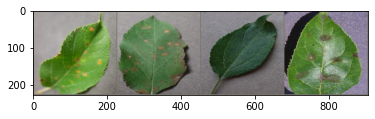

GroundTruth:  Cedar Apple Rust, Cedar Apple Rust, Healthy, Apple Scab
Predicted:  Cedar Apple Rust, Cedar Apple Rust, Healthy, Apple Scab


In [23]:
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ', '.join('%5s' % class_names[x] for x in labels))
images = images.to(device)
labels = images.to(device)
output = model_vgg16(images)
_, predicted = torch.max(output, 1)
print('Predicted: ', ', '.join('%5s' % class_names[x] for x in predicted))

In [24]:
output.shape

torch.Size([4, 4])

In [25]:
class_names

['Apple Scab', 'Black Rot', 'Cedar Apple Rust', 'Healthy']

In [26]:
output.shape

torch.Size([4, 4])

### Save the model

In [27]:
# Save The Model
PATH = './fix_resnet18.pth'
torch.save(model_resnet.state_dict(), PATH)